In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix 

red_wine=pd.read_csv('winequality-red.csv', sep=';')
white_wine=pd.read_csv('winequality-white.csv', sep=';')
red_wine['wine_type_code'] = 0
white_wine['wine_type_code'] = 1
red_wine['wine_type']='red'
white_wine['wine_type']= 'white'
red_wine['quality_label'] = red_wine['quality'].apply(lambda value: 'low'
if value <= 5 else 'medium'
if value <= 7 else 'high')

red_wine['quality_label'] = pd.Categorical(red_wine['quality_label'],
categories=['low', 'medium', 'high'])

white_wine['quality_label'] = white_wine['quality'].apply(lambda value: 'low'
if value <= 5 else 'medium'
if value <= 7 else 'high')

white_wine['quality_label'] = pd.Categorical(white_wine['quality_label'],
categories=['low', 'medium', 'high'])
wines = pd.concat([red_wine, white_wine])
wines = wines.sample(frac=1, random_state=42).reset_index(drop=True)

In [2]:
"""
Created on Mon Jul 31 20:05:23 2017
@author: DIP
@Copyright: Dipanjan Sarkar
"""

from sklearn import metrics
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 


def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                labels=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)


def plot_model_decision_surface(clf, train_features, train_labels,
                                plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):
    
    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = train_features[:, 0].min() - plot_step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot_step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf_est = clone(clf)
    clf_est.fit(train_features,train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)
    
    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                    label=label_names[i], cmap=cmap, edgecolors='black', 
                    marker=markers[i], alpha=alphas[i])
    plt.legend()
    plt.show()


def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1] 
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(y_test, y_score)      
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)
        
    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]), 
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
wtp_features = wines.iloc[:,:-3]
wtp_feature_names = wtp_features.columns
wtp_class_labels = np.array(wines['wine_type'])

wtp_train_X, wtp_test_X, wtp_train_y, wtp_test_y = train_test_split(wtp_features,
wtp_class_labels, test_size=0.3, random_state=42)

print(Counter(wtp_train_y), Counter(wtp_test_y))
print('Features:', list(wtp_feature_names))

Counter({'white': 3418, 'red': 1129}) Counter({'white': 1480, 'red': 470})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [4]:
 # Define the scaler
wtp_ss = StandardScaler().fit(wtp_train_X)
# Scale the train set
wtp_train_SX = wtp_ss.transform(wtp_train_X)
# Scale the test set
wtp_test_SX = wtp_ss.transform(wtp_test_X)

In [5]:
from sklearn.linear_model import LogisticRegression

wtp_lr = LogisticRegression()
wtp_lr.fit(wtp_train_SX, wtp_train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
verbose=0, warm_start=False)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

In [11]:
from sklearn.metrics import classification_report, cohen_kappa_score, precision_recall_curve, balanced_accuracy_score

wtp_lr_predictions = wtp_lr.predict(wtp_test_SX)

print(classification_report(wtp_test_y,wtp_lr_predictions, target_names=['red', 'white']))
print(cohen_kappa_score(wtp_test_y,wtp_lr_predictions))
print(balanced_accuracy_score(wtp_test_y,wtp_lr_predictions))
#print(precision_recall_curve(wtp_test_y, wtp_lr_predictions, sample_weight=None))

              precision    recall  f1-score   support

         red       0.99      0.98      0.99       470
       white       0.99      1.00      1.00      1480

    accuracy                           0.99      1950
   macro avg       0.99      0.99      0.99      1950
weighted avg       0.99      0.99      0.99      1950

0.9817385478723788
0.9898001725129384


Feature: 0, Score: -0.49605
Feature: 1, Score: -1.21198
Feature: 2, Score: 0.37452
Feature: 3, Score: 3.40942
Feature: 4, Score: -0.86940
Feature: 5, Score: -0.52729
Feature: 6, Score: 2.49766
Feature: 7, Score: -3.38781
Feature: 8, Score: -0.39499
Feature: 9, Score: -0.61624
Feature: 10, Score: -1.15267
Feature: 11, Score: -0.24261


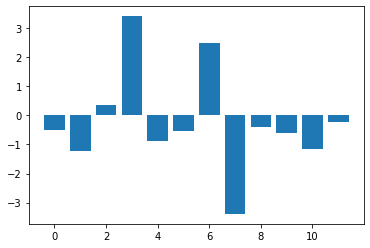

In [15]:
#Feature Reduction
# get importance
importance = wtp_lr.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()